In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [3]:
%load_ext autoreload
%autoreload

import pandas as pd
import pandas_profiling
import numpy as np
import csv
import qgrid
from ipysheet import from_dataframe

from pa_lib.file import load_csv
from pa_lib.data import as_dtype, desc_col
from pa_lib.types import dtFactor, Record

## Load data

In [7]:
def load_ax_data(file_path):
    df = load_csv(file_path, sep=';', quoting=csv.QUOTE_NONE, encoding='cp1252')
    df.DayOfWeek = df.DayOfWeek.astype('category').cat.reorder_categories(
        'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split(), 
        ordered=True)
    df = (df
          .assign(logValue=np.log(df.Value))
          .sort_values(by=['Station', 'DayOfWeek', 'Variable', 'Code'])
          .reset_index(drop=True))
    return df
    
ax = pd.concat([
    load_ax_data('axinova_20190606/190016Wochentage.csv'),
    load_ax_data('axinova_20190808/190016Wochentage.csv')
])

var = Record(**{v:v for v in np.unique(ax.Variable)})
display(desc_col(ax, det=True))

2019-09-02 10:41:57 [INFO] Reading from file C:\Users\kpf\data\axinova_20190606\190016Wochentage.csv
2019-09-02 10:41:57 [INFO] Finished loading CSV in 0.03s (0.03s CPU)
2019-09-02 10:41:57 [INFO] Reading from file C:\Users\kpf\data\axinova_20190808\190016Wochentage.csv
2019-09-02 10:41:57 [INFO] Finished loading CSV in 0.04s (0.23s CPU)


,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,object,0/100159,25,8.4 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/100159,7,881.1 KB,"[Monday,Sunday]"
Variable,object,0/100159,119,6.9 MB,"[g_220,nat_ausland]"
Code,object,0/100159,153,8.1 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter..."
Value,float64,0/100159,79664,1.5 MB,"[0.442782048,1315.804897]"
logValue,float64,0/100159,79664,1.5 MB,"[-0.8146776209749247,7.182203846335199]"


In [ ]:
pandas_profiling.ProfileReport(ax).to_file(outputfile='ax_profile.html')

In [ ]:
from_dataframe(ax)

## Check code distributions

In [8]:
ax.DayOfWeek.value_counts()

Friday       14563
Wednesday    14375
Sunday       14303
Thursday     14291
Saturday     14290
Monday       14175
Tuesday      14162
Name: DayOfWeek, dtype: int64

In [9]:
ax.Station.value_counts()

Zürich HB             4819
Bern                  4565
Zürich Oerlikon       4438
Zürich Hardbrücke     4323
Olten                 4323
Luzern                4309
Zürich Flughafen      4308
Basel SBB             4295
Zürich Stadelhofen    4248
Lausanne              4208
Zug                   4185
Aarau                 4160
Winterthur            4156
Genève Cornavin       4091
Fribourg              4074
Biel/Bienne           4025
Lugano                4024
St. Gallen            3915
Zürich Enge           3823
Genève Aéroport       3781
Bellinzona            3748
Neuchatel             3652
Chur                  3481
Brig                  3447
M2                    1761
Name: Station, dtype: int64

In [10]:
ax.Variable.value_counts()

md_gebiet      3882
md_kanton      3667
md_880         3263
md_standort    3190
md_hhverm      2331
               ... 
g_530           318
g_505           310
g_534           287
g_533           272
g_515           243
Name: Variable, Length: 119, dtype: int64

In [11]:
ax.Code.value_counts()

not quoted               27105
quoted                   21916
regelmässig               3073
gelegentlich              3015
nie                       2459
                         ...  
Obwalden                    36
Nidwalden                   32
mehrmals pro Monat          24
Appenzell Innerrhoden       16
einmal pro Woche             1
Name: Code, Length: 153, dtype: int64

## Distribution of codes within variables

### Overall

In [12]:
ax.groupby(by=['Variable', 'Code'], observed=True)[['Value']].agg('sum').astype('int')

Value
Variable    Code              
g_220       1 Auto       32184
            2+ Autos     19356
            Keines       19953
g_500       not quoted   39608
            quoted       31689
...                        ...
md_zivil    ledig        36505
            verheiratet  24658
            verwitwet      996
nat_ausland not quoted   52548
            quoted       18946

[371 rows x 1 columns]

### Split by Station

In [13]:
ax.pivot_table(
    values="Value",
    index=["Variable", "Code"],
    columns="Station",
    aggfunc="sum",
    margins=True,
).fillna(0).astype("int")

Station                   Aarau  Basel SBB  Bellinzona    Bern  Biel/Bienne  \
Variable    Code                                                              
g_220       1 Auto         1059       1283         296    3165          976   
            2+ Autos        631        610         288    2096          495   
            Keines          676       1146          74    2100          625   
g_500       not quoted     1130       1608         306    3858         1182   
            quoted         1228       1432         349    3499          913   
...                         ...        ...         ...     ...          ...   
md_zivil    verheiratet    1000       1064         358    2649          669   
            verwitwet        41        124           3      40            6   
nat_ausland not quoted     1956       2201         400    5710         1607   
            quoted          409        839         258    1651          489   
All                      207833     280985       60438  665991       190182   

Station                   Brig   Chur  Fribourg  Genève Aéroport  \
Variable    Code                                                   
g_220       1 Auto         271    399       752              326   
            2+ Autos       236    246      1355              410   
            Keines          52    132       371               95   
g_500       not quoted     431    325      1865              508   
            quoted         129    452       611              321   
...                        ...    ...       ...              ...   
md_zivil    verheiratet    208    288       593              407   
            verwitwet        2     10        10                5   
nat_ausland not quoted     499    396      2113              444   
            quoted          61    381       365              387   
All                      51952  69989    223568            74493   

Station                  Genève Cornavin  ...  St. Gallen  Winterthur     Zug  \
Variable    Code                          ...                                   
g_220       1 Auto                  1458  ...         659        1426    1402   
            2+ Autos                 505  ...         498         805     514   
            Keines                   908  ...         804         998     624   
g_500       not quoted              1977  ...        1127        1638    1268   
            quoted                   894  ...         834        1579    1267   
...                                  ...  ...         ...         ...     ...   
md_zivil    verheiratet              735  ...         415        1148     814   
            verwitwet                 83  ...           4          56      20   
nat_ausland not quoted              1522  ...        1043        2595    1952   
            quoted                  1350  ...         918         634     589   
All                               260751  ...      180647      287730  237401   

Station                  Zürich Enge  Zürich Flughafen  Zürich HB  \
Variable    Code                                                    
g_220       1 Auto               446               649       5757   
            2+ Autos             335               877       2731   
            Keines               251               265       3819   
g_500       not quoted           580               807       6769   
            quoted               447               981       5468   
...                              ...               ...        ...   
md_zivil    verheiratet          385               920       4586   
            verwitwet              3                 8        147   
nat_ausland not quoted           738              1403       9763   
            quoted               294               389       2544   
All                            92653            160206    1113657   

Station                  Zürich Hardbrücke  Zürich Oerlikon  \
Variable    Code                                              
g_220    

### Split by Weekday

In [14]:
tmp = ax.pipe(as_dtype, "object", incl_col="DayOfWeek")
tmp.pivot_table(
    values="Value",
    index=["Variable", "Code"],
    columns="DayOfWeek",
    aggfunc="sum",
    margins=True,
).fillna(0).astype("int").loc[
    :, "Monday Tuesday Wednesday Thursday Friday Saturday Sunday All".split()
]

DayOfWeek                Monday  Tuesday  Wednesday  Thursday   Friday  \
Variable    Code                                                         
g_220       1 Auto         4981     5239       5402      4958     5310   
            2+ Autos       2790     3204       3269      2938     3358   
            Keines         2917     3068       3197      2687     3215   
g_500       not quoted     5802     6249       6520      5847     6672   
            quoted         4860     5240       5304      4718     5189   
...                         ...      ...        ...       ...      ...   
md_zivil    verheiratet    3791     4275       4341      3918     4108   
            verwitwet       164      153        124       113      149   
nat_ausland not quoted     7711     8442       8604      7927     8585   
            quoted         2978     3069       3265      2657     3298   
All                      967401  1041769    1074996    962248  1074354   

DayOfWeek                Saturday  Sunday      All  
Variable    Code                                    
g_220       1 Auto           3609    2682    32184  
            2+ Autos         2142    1652    19356  
            Keines           2575    2292    19953  
g_500       not quoted       4720    3796    39608  
            quoted           3587    2790    31689  
...                           ...     ...      ...  
md_zivil    verheiratet      2394    1826    24658  
            verwitwet         185     104      996  
nat_ausland not quoted       6362    4913    52548  
            quoted           1964    1712    18946  
All                        748586  595514  6464872  

[372 rows x 8 columns]

In [15]:
del(tmp)

## Pivot tables (sum of "Value")

### Stations vs. Weekdays

In [16]:
ax.pivot_table(
    values="Value", index="Station", columns="DayOfWeek", aggfunc="sum", margins=True
).astype("int").sort_values('All')

DayOfWeek,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,All
Station,,,,,,,,
M2,4205,3225,3560,2854,5387,2972,1755,23961
Brig,6084,7186,8221,6968,8784,9469,5237,51952
Bellinzona,10238,7494,8525,7727,11742,6521,8188,60438
Chur,11874,9357,8257,10360,13996,7353,8789,69989
Genève Aéroport,10030,10192,11342,10832,11902,10649,9544,74493
Neuchatel,13203,15143,13887,11141,14275,9310,8437,85399
Zürich Enge,12266,13571,15551,14385,17510,12141,7226,92653
Zürich Flughafen,24587,19043,24789,18802,24874,22492,25615,160206
Lugano,23931,27772,24431,24011,29166,19185,16727,165226


### Variables vs. Stations

In [17]:
ax.pivot_table(
    values="Value", index="Variable", columns="Station", aggfunc="sum", margins=True
).fillna(0).astype("int").sort_values("All")

Station,Aarau,Basel SBB,Bellinzona,Bern,Biel/Bienne,Brig,Chur,Fribourg,Genève Aéroport,Genève Cornavin,...,St. Gallen,Winterthur,Zug,Zürich Enge,Zürich Flughafen,Zürich HB,Zürich Hardbrücke,Zürich Oerlikon,Zürich Stadelhofen,All
Variable,,,,,,,,,,,,,,,,,,,,,
g_534,7,42,432,26,2,4,13,33,3,14,...,5,95,70,24,37,330,128,133,161,3032
g_533,7,42,432,26,2,4,13,33,3,14,...,5,95,70,24,37,330,128,133,161,3032
g_532,7,42,432,26,2,4,13,33,3,14,...,5,95,70,24,37,330,128,133,161,3032
g_531,7,42,432,26,2,4,13,33,3,14,...,5,95,70,24,37,330,128,133,161,3032
g_530,7,42,432,26,2,4,13,33,3,14,...,5,95,70,24,37,330,128,133,161,3032
g_515,22,29,6,397,365,8,12,864,264,962,...,17,15,39,8,22,174,63,43,73,5206
g_517,49,93,21,787,973,38,15,1991,720,2542,...,38,41,90,24,66,509,239,123,208,14137
g_520,49,93,21,801,1000,38,15,2015,754,2609,...,38,42,90,25,68,520,240,124,208,14558
g_519,49,93,21,801,1000,38,15,2015,754,2609,...,38,42,90,25,68,520,240,124,208,14558


### Variables vs. Weekdays

In [18]:
ax.pivot_table(
    values="Value", index="Variable", columns="DayOfWeek", aggfunc="sum", margins=True
).fillna(0).astype("int").sort_values("All")

DayOfWeek,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,All
Variable,,,,,,,,
g_534,403,470,503,447,521,317,369,3032
g_533,403,470,503,447,521,317,369,3032
g_532,403,470,503,447,521,317,369,3032
g_531,403,470,503,447,521,317,369,3032
g_530,403,470,503,447,521,317,369,3032
g_515,827,896,971,813,822,470,404,5206
g_517,2207,2352,2380,2129,2391,1510,1165,14137
g_520,2275,2421,2471,2201,2464,1525,1199,14558
g_519,2275,2421,2471,2201,2464,1525,1199,14558


## Tests for Independence

In [19]:
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set(rc={'figure.dpi': 90, 'figure.figsize': [20, 10]})

In [20]:
def plot_tables(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    print(f'Test by weekday: p={table_by_weekday.test_nominal_association().pvalue:.3f}')
    print(f'Test by station: p={table_by_station.test_nominal_association().pvalue:.3f}')  
    plt.subplot(1, 2, 1)
    sns.heatmap(table_by_weekday.resid_pearson, center=0)
    plt.subplot(1, 2, 2)
    sns.heatmap(table_by_station.resid_pearson, center=0)
    
def table_stats(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    p_weekday = table_by_weekday.test_nominal_association().pvalue
    p_station = table_by_station.test_nominal_association().pvalue
    return {'var': variable, 'p_weekday': p_weekday, 'p_station': p_station}

In [21]:
%%time
all_var_tables = pd.DataFrame.from_records(
    columns='var p_weekday p_station'.split(),
    data=[table_stats(v) for v in var],
    index='var'
)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\contingency_tables.py:329: RuntimeWarning: invalid value encountered in sqrt
  resids = (self.table - fit) / np.sqrt(fit)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


Wall time: 4.68 s


In [27]:
all_var_tables.loc[all_var_tables.p_station <= 0.05].sort_values('p_weekday')

,p_weekday,p_station
var,,
g_flugBusiness,0.001617,0.000000e+00
md_384,0.034871,2.031962e-09
md_307,0.089191,8.318253e-07
md_standort,0.106604,0.000000e+00
md_327,0.377919,0.000000e+00
g_517,0.395330,0.000000e+00
md_415,0.419020,0.000000e+00
g_508,0.542081,0.000000e+00
md_hhu6,0.544661,7.536795e-05


Test by weekday: p=0.035
Test by station: p=0.000


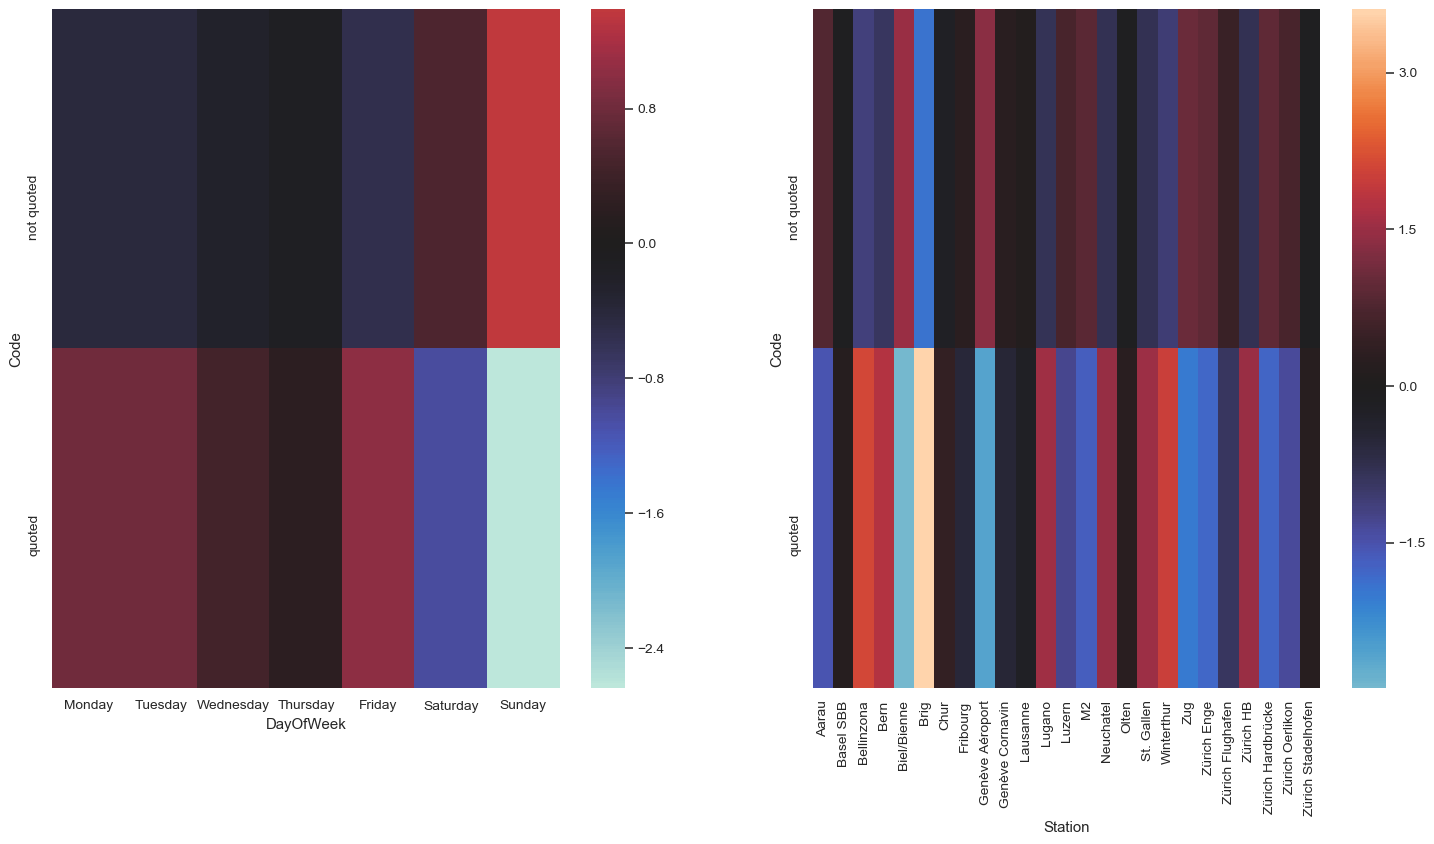

In [30]:
plot_tables(var.md_384)

Test by weekday: p=1.000
Test by station: p=0.000


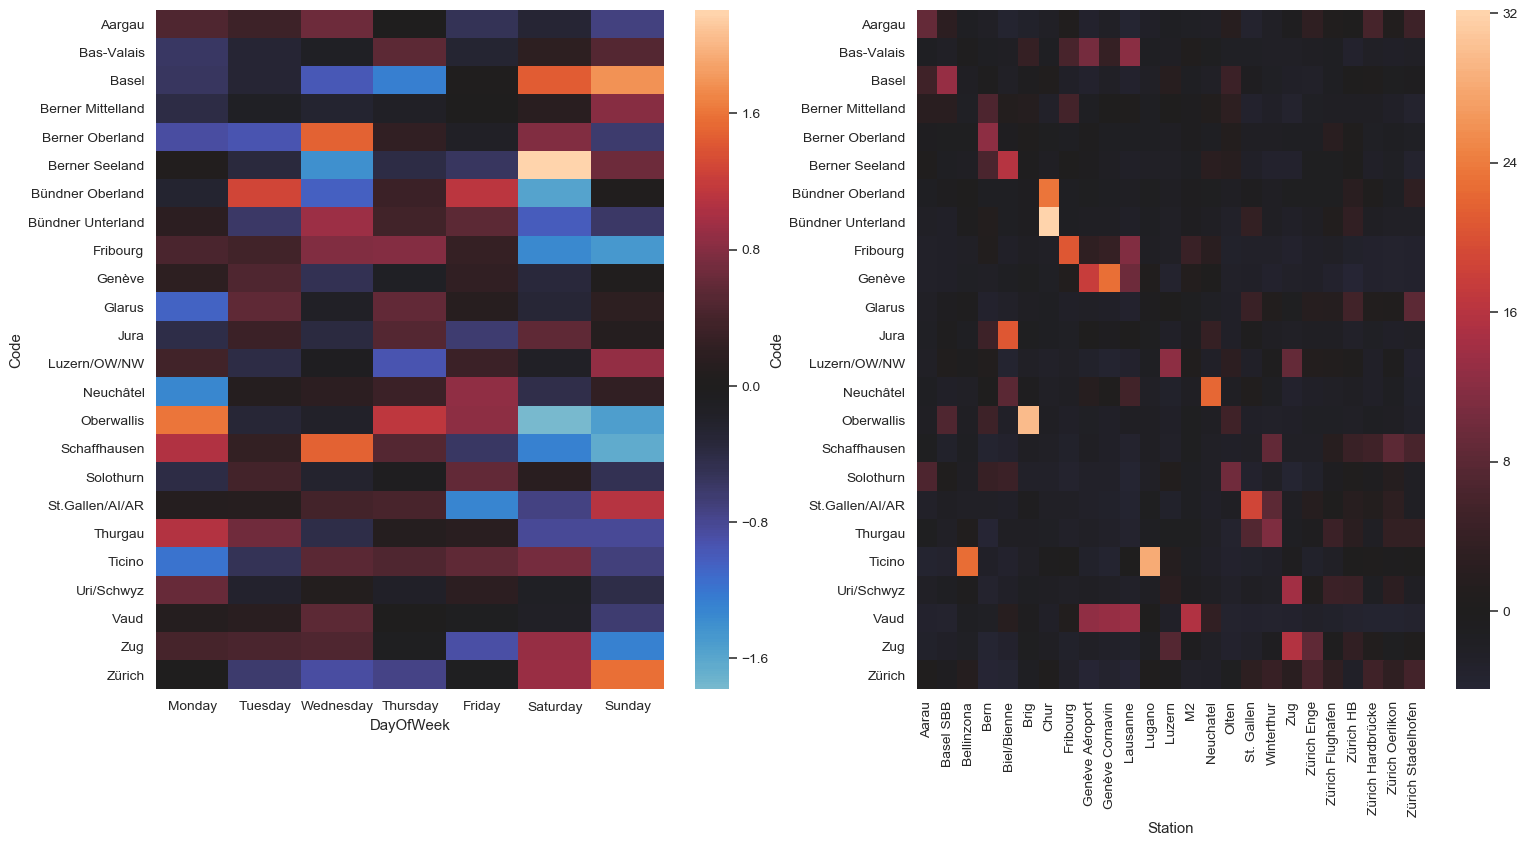

In [31]:
plot_tables('md_gebiet')

Test by weekday: p=0.937
Test by station: p=0.000


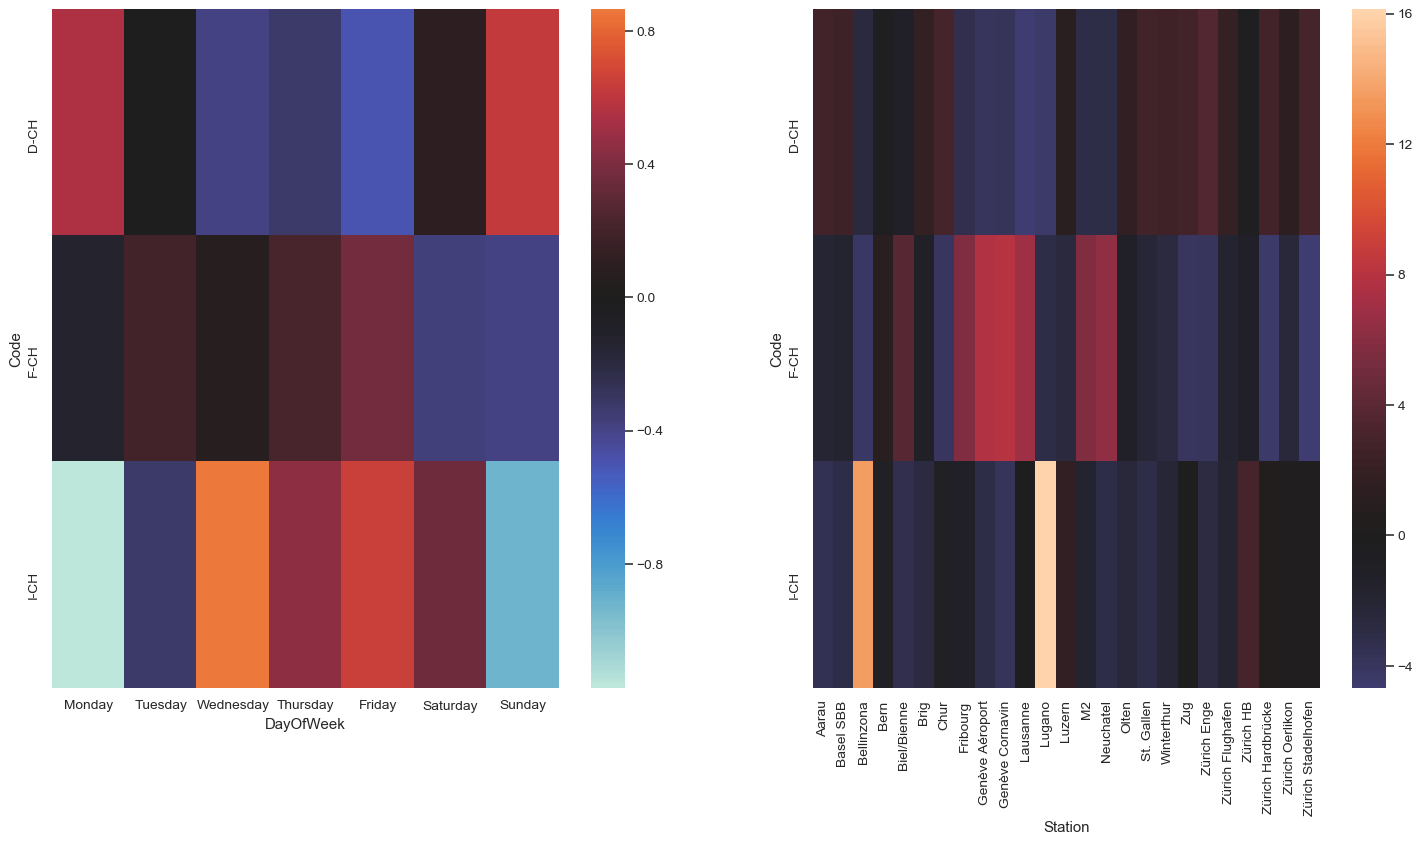

In [32]:
plot_tables('g_sprachregion')

Test by weekday: p=1.000
Test by station: p=0.000


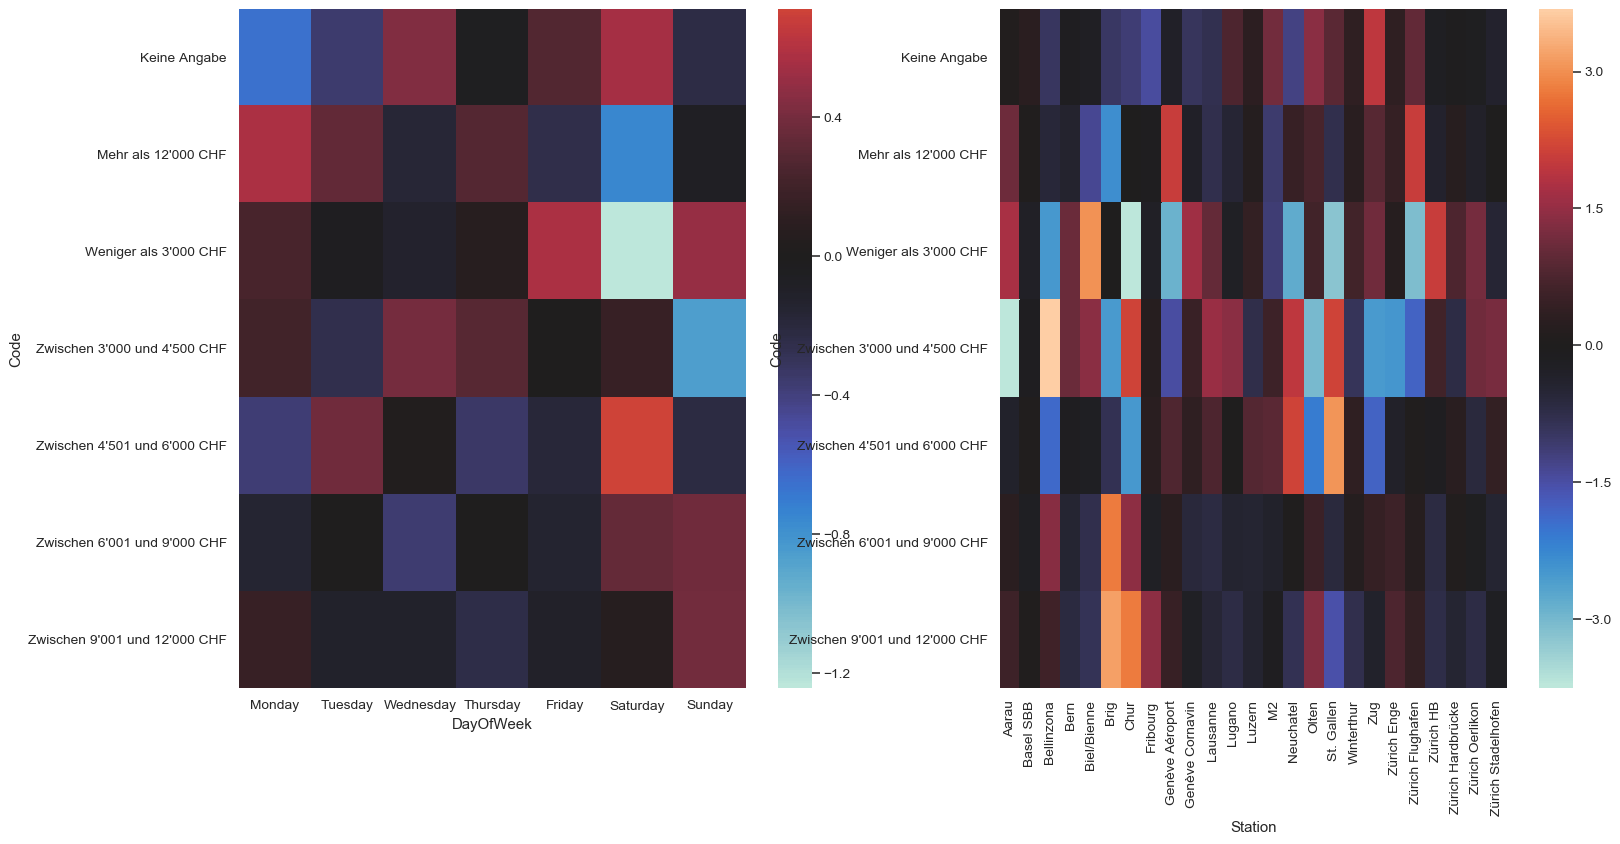

In [33]:
plot_tables('md_ek')

Test by weekday: p=0.994
Test by station: p=0.000


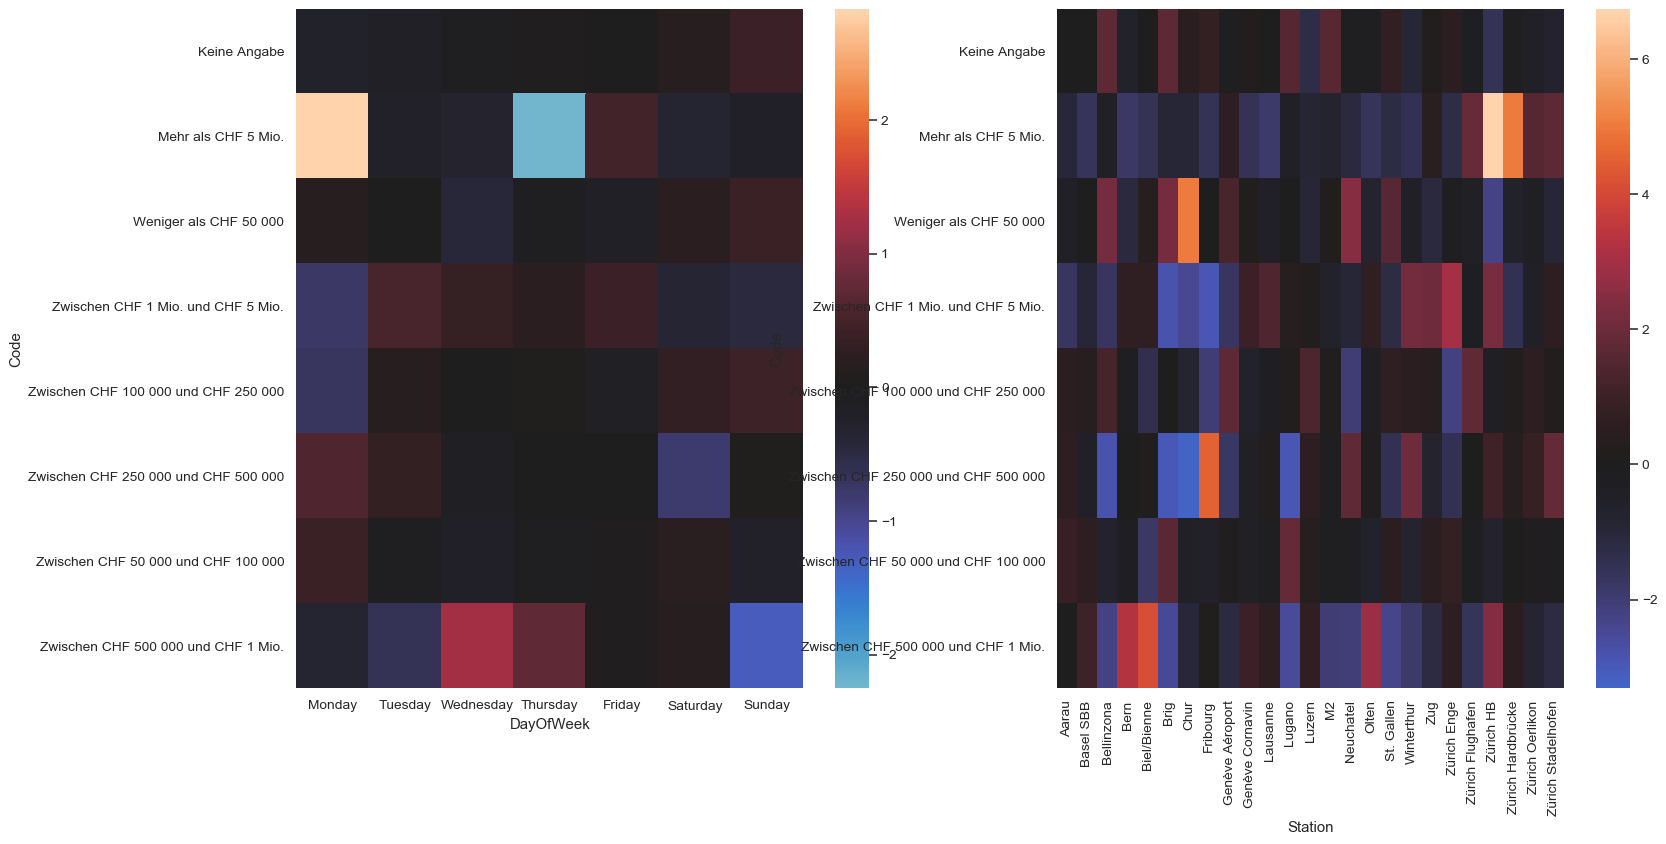

In [34]:
plot_tables('md_hhverm')

Test by weekday: p=1.000
Test by station: p=0.000


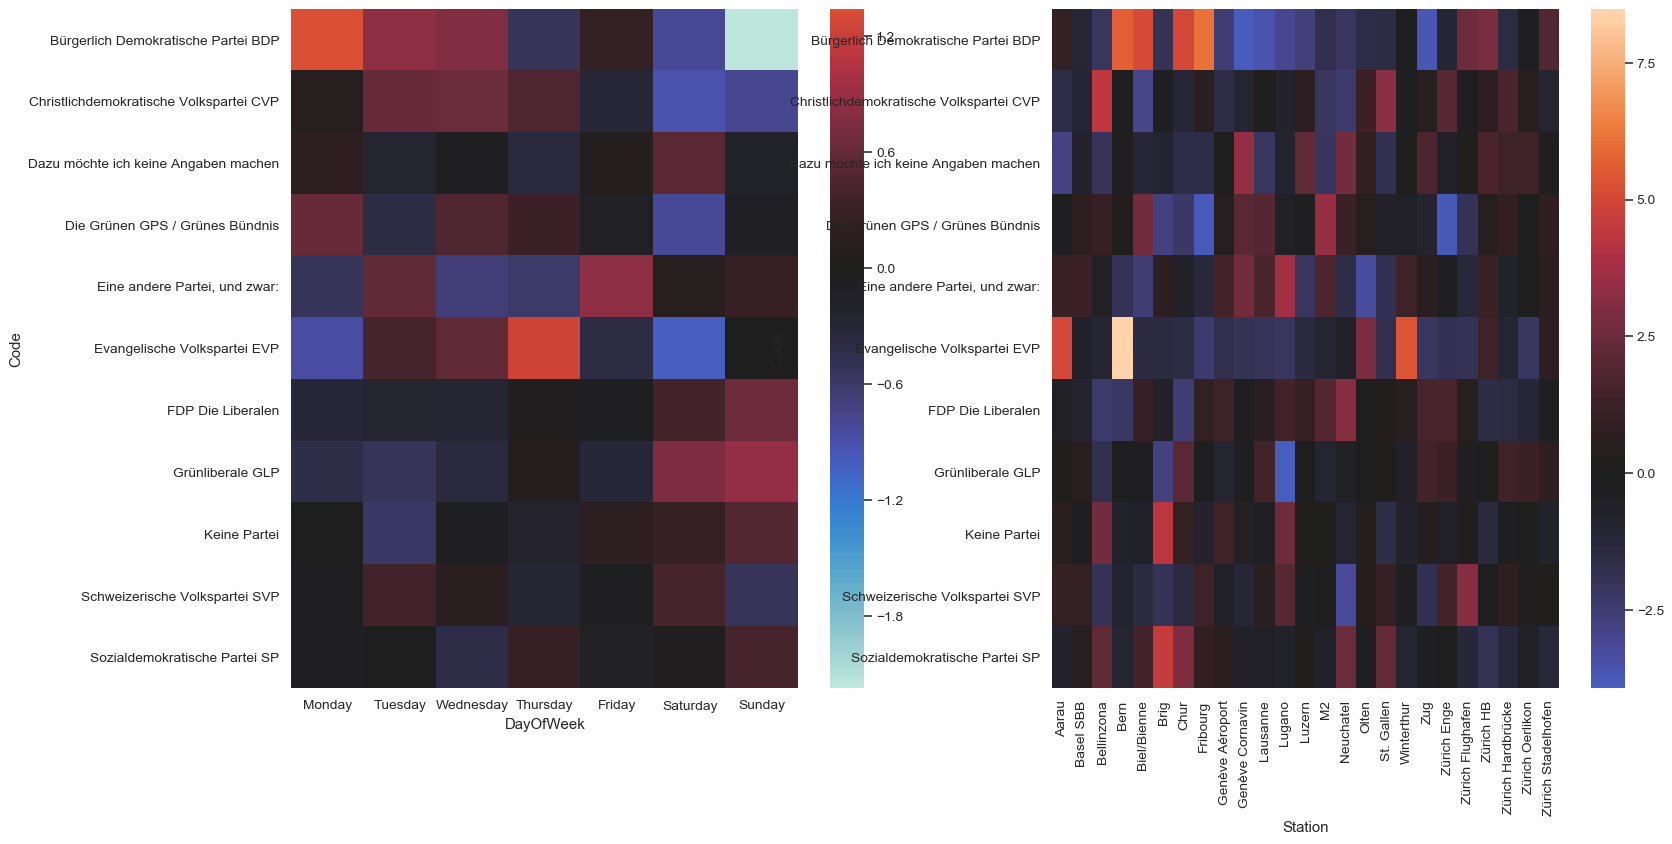

In [35]:
plot_tables('md_880')

Test by weekday: p=0.998
Test by station: p=0.000


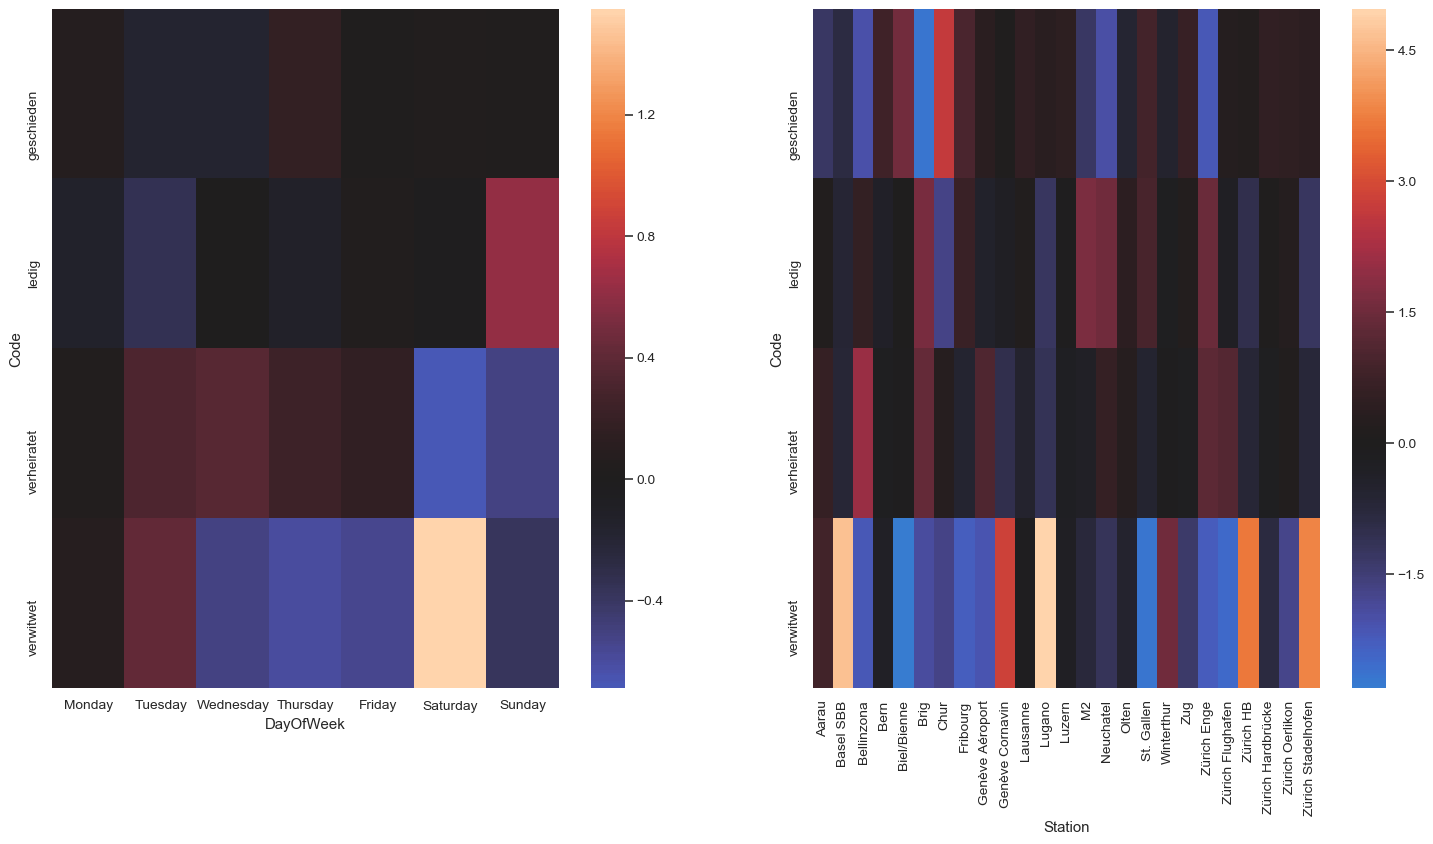

In [36]:
plot_tables(var.md_zivil)

## Models

### ANOVA

In [37]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.graphics.regressionplots as spl

In [38]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def calc_anova(variable, formula='logValue ~ Code + Station + DayOfWeek'):
    data = ax.loc[ax.Variable==variable]
    data = data.assign(label=data.Station.str.cat([data.DayOfWeek.str[:3], data.Code], sep='|'))
    data.set_index('label', inplace=True)
    mod = smf.ols(formula=formula, data=data)
    res = mod.fit()
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())
    #print(res.get_influence().summary_table())
    #spl.influence_plot(res)
    #sns.catplot(x="Station", y='logValue', col='DayOfWeek', kind="box", col_wrap=2, data=ax.loc[ax.Variable==variable])
    
def anova_stats(variable):
    """ANOVA statistics"""
    data = ax.loc[ax.Variable==variable]
    #
    lm_station =      smf.ols(formula='logValue ~ Code + Station', data=data).fit()
    lm_weekday =      smf.ols(formula='logValue ~ Code + DayOfWeek', data=data).fit()
    lm_full =         smf.ols(formula='logValue ~ Code + Station + DayOfWeek', data=data).fit()
    lm_code_station = smf.ols(formula='logValue ~ Code * Station', data=data).fit()
    lm_code_weekday = smf.ols(formula='logValue ~ Code * DayOfWeek', data=data).fit()
    #
    return {'var':variable, 'code+station+weekday':lm_full.rsquared, 'code*station': lm_code_station.rsquared, 'code*weekday': lm_code_weekday.rsquared, 
            'code+station':lm_station.rsquared, 'p_code_station':lm_station.f_pvalue, 'code+weekday':lm_weekday.rsquared}

In [39]:
all_var_stats = pd.DataFrame.from_records(
    columns='var code+station+weekday code*station code*weekday code+station p_code_station code+weekday'.split(),
    data=[anova_stats(v) for v in var.keys()],
    index='var'
)

all_var_stats = all_var_stats.assign(**{
    'plus_weekday':      np.subtract(all_var_stats['code+station+weekday'], all_var_stats['code+station']),
    'plus_code*station': np.subtract(all_var_stats['code*station'], all_var_stats['code+station']),
    'plus_code*weekday': np.subtract(all_var_stats['code*weekday'], all_var_stats['code+station']),
})

In [40]:
all_var_stats.loc[
    :,
    "code+station p_code_station plus_weekday plus_code*station plus_code*weekday".split(),
].sort_values("code+station")

,code+station,p_code_station,plus_weekday,plus_code*station,plus_code*weekday
var,,,,,
md_gebiet,0.211907,6.102498e-162,0.006894,0.627995,-0.052624
md_kanton,0.233455,7.480926e-171,0.005494,0.611268,-0.052355
md_standort,0.258881,5.137521e-166,0.007982,0.572763,-0.036643
md_region,0.267522,7.627859e-75,0.004254,0.632808,-0.101066
g_sprachregion,0.475227,1.658660e-94,0.003069,0.459671,-0.069793
md_880,0.615432,0.000000e+00,0.019209,0.171075,-0.337025
md_ek,0.662955,0.000000e+00,0.022789,0.132948,-0.427465
g_privatetrainuse,0.687568,0.000000e+00,0.016162,0.178591,-0.222179
g_534,0.691563,8.649530e-53,0.013634,0.105428,-0.573747


In [41]:
calc_anova(var.md_zivil, formula='logValue ~ Code + Station')

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Code,1549.160473,3.0,516.386824,1402.839324,0.000000e+00,0.584346,0.583848
Station,665.006712,24.0,27.708613,75.274446,1.299410e-218,0.250841,0.247475
Residual,436.936112,1187.0,0.368101,NaN,NaN,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:               logValue   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     199.0
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:15:49   Log-Likelihood:                -1102.7
No. Observations:                1215   AIC:                             2261.
Df Residuals:                    1187   BIC:                             2404.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     